In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip  /content/drive/MyDrive/veri.zip

Archive:  /content/drive/MyDrive/veri.zip
   creating: bus/
   creating: sedan/
   creating: suv/
   creating: truck/
   creating: van/
  inflating: suv/0009_c014_00070065_0.jpg  
  inflating: suv/0006_c016_00026265_0.jpg  
  inflating: suv/0009_c014_00089220_0.jpg  
  inflating: suv/0006_c015_00024710_0.jpg  
  inflating: suv/0006_c014_00022360_0.jpg  
  inflating: suv/0006_c015_00022395_0.jpg  
  inflating: suv/0006_c015_00022385_0.jpg  
  inflating: suv/0009_c013_00067840_0.jpg  
  inflating: suv/0006_c015_00022390_0.jpg  
  inflating: suv/0006_c015_00024715_0.jpg  
  inflating: suv/0006_c014_00024885_0.jpg  
  inflating: suv/0009_c014_00070055_0.jpg  
  inflating: suv/0009_c015_00069855_0.jpg  
  inflating: suv/0009_c014_00070070_0.jpg  
  inflating: suv/0006_c015_00022380_0.jpg  
  inflating: suv/0006_c015_00024720_0.jpg  
  inflating: suv/0009_c014_00089270_0.jpg  
  inflating: suv/0009_c001_00067380_0.jpg  
  inflating: suv/0006_c014_00024870_0.jpg  
  inflating: suv/0006_c015_0

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
import numpy as np
from PIL import Image

# Path to your dataset
dataset_path = '/content/veri'

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to fit the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset using ImageFolder
dataset = ImageFolder(root=dataset_path, transform=transform)

# Split dataset into training and validation sets
def split_dataset(dataset, train_ratio=0.8):
    num_samples = len(dataset)
    indices = list(range(num_samples))
    split = int(np.floor(train_ratio * num_samples))
    np.random.shuffle(indices)
    train_indices, val_indices = indices[:split], indices[split:]
    train_subset = torch.utils.data.Subset(dataset, train_indices)
    val_subset = torch.utils.data.Subset(dataset, val_indices)
    return train_subset, val_subset

train_dataset, val_dataset = split_dataset(dataset)

# Create DataLoaders for training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Create a model
def create_model(num_classes):
    model = models.resnet50(pretrained=True)
    in_features = model.fc.in_features
    model.fc = torch.nn.Linear(in_features, num_classes)
    return model

# Define training and validation procedures
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {val_accuracy}%')

# Determine the number of classes
num_classes = len(dataset.classes)  # Number of unique classes

# Create and train the model
model = create_model(num_classes)
train_model(model, train_dataloader, val_dataloader)

# Save the fine-tuned model
torch.save(model.state_dict(), 'fine_tuned_resnet50.pth')

print('Model fine-tuned and saved successfully.')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can als

Epoch 1/10, Training Loss: 0.7561119904120763, Validation Loss: 3.0325359106063843, Validation Accuracy: 60.924369747899156%
Epoch 2/10, Training Loss: 0.3767139971256256, Validation Loss: 2.09939406812191, Validation Accuracy: 61.34453781512605%
Epoch 3/10, Training Loss: 0.2933286088208357, Validation Loss: 1.6454131677746773, Validation Accuracy: 63.02521008403362%
Epoch 4/10, Training Loss: 0.15390642577161393, Validation Loss: 0.6229482181370258, Validation Accuracy: 81.9327731092437%
Epoch 5/10, Training Loss: 0.1864482776882748, Validation Loss: 0.7958154696971178, Validation Accuracy: 82.77310924369748%
Epoch 6/10, Training Loss: 0.22205986243983108, Validation Loss: 0.27779199928045273, Validation Accuracy: 88.23529411764706%
Epoch 7/10, Training Loss: 0.09121231107662121, Validation Loss: 0.12440846487879753, Validation Accuracy: 93.69747899159664%
Epoch 8/10, Training Loss: 0.1287186538334936, Validation Loss: 1.1580874063074589, Validation Accuracy: 73.52941176470588%
Epoch

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Top 5 similar vehicles:
0298_c019_00045845_1.jpg: 0.9964
0299_c006_00076910_0.jpg: 0.9835
0241_c015_00035625_0.jpg: 0.9678
0192_c005_00079400_0.jpg: 0.3801
0173_c019_00068370_0.jpg: 0.3546


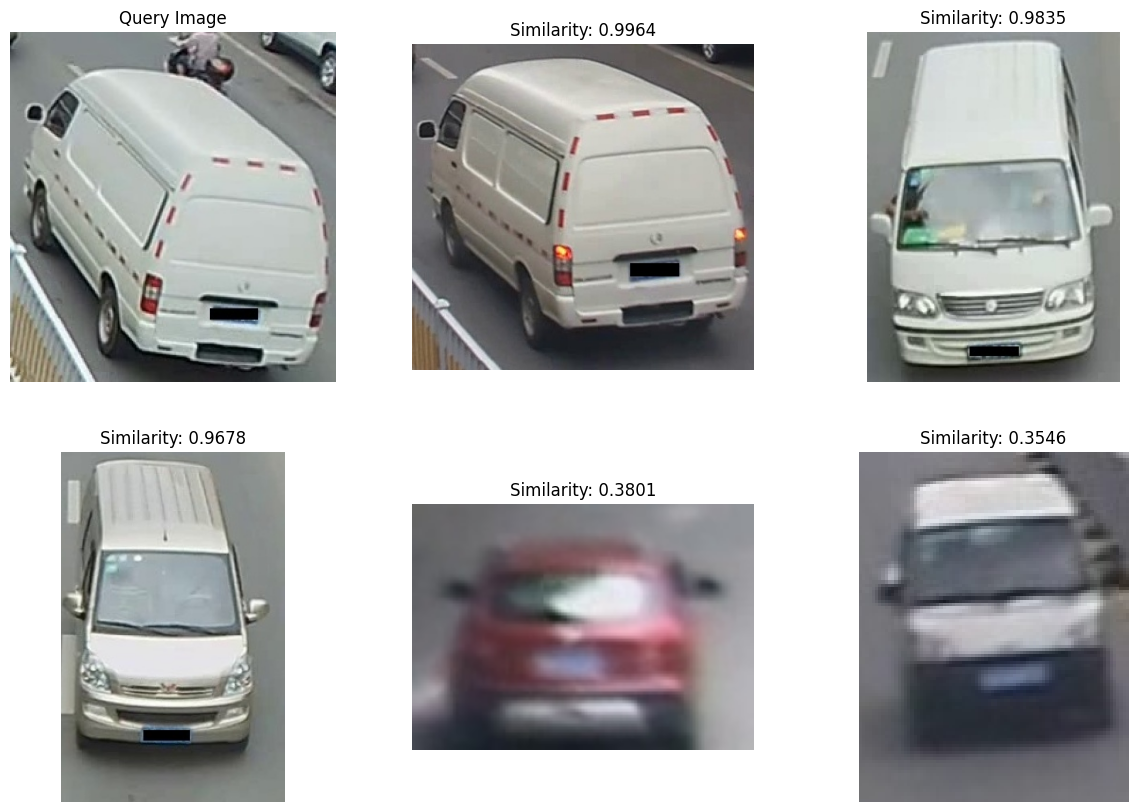

In [12]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load the fine-tuned model
num_classes = 5  # Set this to the correct number of classes in your dataset
model = models.resnet50(pretrained=False)
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/fine_tuned_resnet50.pth'))
model.eval()

# Preprocessing function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = Image.open(image_path).convert('RGB')  # Ensure image is in RGB format
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    return img_tensor

# Extract features
def extract_features(image_path, model):
    img_tensor = preprocess_image(image_path)
    with torch.no_grad():
        features = model(img_tensor)
    return features.squeeze().numpy()

# Compare images using cosine similarity
def reidentify_vehicle(query_image_path, database_dir, model):
    query_features = extract_features(query_image_path, model)
    similarities = []

    for image_name in os.listdir(database_dir):
        db_image_path = os.path.join(database_dir, image_name)
        db_features = extract_features(db_image_path, model)
        similarity = cosine_similarity([query_features], [db_features])[0][0]
        similarities.append((db_image_path, similarity))

    # Sort by similarity in descending order
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities

# Test the re-identification system and display results
def test_reid_system(query_image_path, database_dir):
    results = reidentify_vehicle(query_image_path, database_dir, model)

    # Show the query image
    query_img = Image.open(query_image_path)
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(query_img)
    plt.title('Query Image')
    plt.axis('off')

    # Display top 5 matches
    print("Top 5 similar vehicles:")
    for i, (db_image_path, score) in enumerate(results[:5], start=2):
        matched_img = Image.open(db_image_path)
        plt.subplot(2, 3, i)
        plt.imshow(matched_img)
        plt.title(f'Similarity: {score:.4f}')
        plt.axis('off')
        print(f'{os.path.basename(db_image_path)}: {score:.4f}')

    plt.show()

# Example usage
if __name__ == "__main__":
    query_image_path = '/content/aa.jpg'
    database_directory = '/content/query/'

    # Test the re-identification system
    test_reid_system(query_image_path, database_directory)
